In [148]:
# LEGEND specific imports
from lgdo import lh5

# MISC
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import awkward as ak
import glob
from iminuit import cost, Minuit
from numba_stats import truncnorm, truncexpon

In [5]:
# Just some paths
DSP_PATH = "/mnt/c/Users/pkrau/OneDrive/Dokumente/GitHub/mint-analysis/data/gain_cal/dsp/"

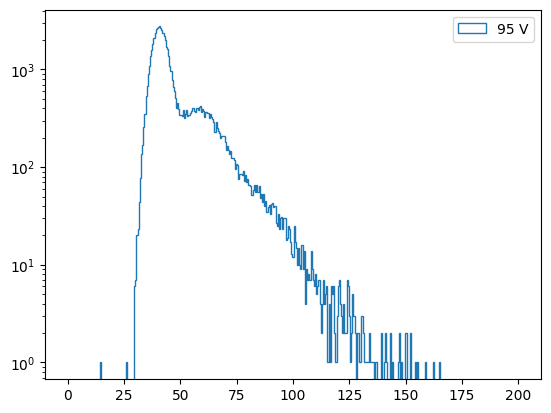

In [7]:
f_dsp = glob.glob(DSP_PATH+"*.lh5")

fig, ax = plt.subplots()
for f in f_dsp:
    voltage= f.split("_")[-2]

    trig_dsp = lh5.read_as("ch013/dsp",f,"ak")
    pmt_dsp = lh5.read_as("ch002/dsp",f,"ak")

    ax.hist(ak.nansum(pmt_dsp.nnls_solution.values,axis=-1),bins=np.linspace(0,200,400),histtype="step",label=f"{voltage} V")
ax.set_yscale('log')
ax.legend()

In [152]:
def get_calib_curve(data,nbins=400,gw_init=5, tau_init=10,display_fit_stats=True,plot_fit=True):
    # Bin the data
    bins = np.linspace(0,np.max(data),nbins)
    bin_counts, edges = np.histogram(data,bins=bins)
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    xr =(0,np.max(data))

    # Define the extended model for the photoelectron spectrum
    def extended_model(x, amp1, cen1, wid1, amp2, cen2, wid2,amp3,cen3,tau):
        """Model with multiple Gaussian peaks and noise."""
        gauss1 = amp1 * truncnorm.cdf(x, xr[0], xr[1], loc=cen1, scale=wid1)
        gauss2 = amp2 * truncnorm.cdf(x, xr[0], xr[1], loc=cen2, scale=wid2)
        noise = amp3 * truncexpon.cdf(x, xr[0], xr[1], loc=cen3, scale=tau)
        return gauss1 + gauss2   + noise

    # Construct the extended binned negative log-likelihood cost
    nll = cost.ExtendedBinnedNLL(bin_counts, edges, extended_model)

    # Perform the fit with initial guesses
    y_max = np.argmax(bin_counts)
    y_amp = np.sum(bin_counts[(bin_centers< bin_centers[y_max]+2*gw_init) & (bin_centers> bin_centers[y_max]-2*gw_init)])
    y2_max = np.argmax(np.where(bin_centers>(bin_centers[y_max]+4*gw_init),bin_counts,0))
    y2_amp = np.sum(bin_counts[(bin_centers< bin_centers[y2_max]+2*gw_init) & (bin_centers> bin_centers[y2_max]-2*gw_init)])

    initial_guess = [y_amp, gw_init, bin_centers[y_max], 
                    y2_amp, gw_init, bin_centers[y2_max],
                    bin_counts[y_max], gw_init, tau_init]
 
    m = Minuit(nll, *initial_guess)
    m.limits["amp1", "amp2", "amp3"] = (0, None)
    m.migrad(iterate=30)  # Perform minimization

    if display_fit_stats:
        display(m.fmin)
        display(m.params)
        # display(m.covariance)


    # Evaluate the model with the fitted parameters
    fitted_model = np.diff(extended_model(bin_centers, *m.values))

    # Plot the data and the fit (if desired)
    if plot_fit:
        plt.figure(figsize=(10, 6))
        plt.errorbar(bin_centers, bin_counts, yerr=np.sqrt(bin_counts), fmt='s', label='Data',zorder=0)
        plt.plot(bin_centers[1:], fitted_model, label='Fit', color='red', linewidth=2)  # Scale by bin widths
        plt.xlabel("Charge (a.u.)")
        plt.ylabel("Counts")
        plt.legend()
        plt.show()

    # calc calib parameters y = a*x + b
    b = m.values['cen1']/(m.values['cen1']-m.values['cen2'])
    a = 1/(m.values['cen2']- m.values['cen1'])
    
    return a, b


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 812 (χ²/ndof = 2.1)        │             Nfcn = 2031              │
│ EDM = 3.19e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,amp1,37.58e3,0.31e3,,,0,,
1,cen1,40.81,0.02,,,,,
2,wid1,3.098,0.017,,,,,
3,amp2,12.74e3,0.32e3,,,0,,
4,cen2,58.63,0.19,,,,,
5,wid2,9.56,0.17,,,,,
6,amp3,13.8e3,0.5e3,,,0,,
7,cen3,34.644,0.031,,,,,
8,tau,21.34,0.33,,,,,


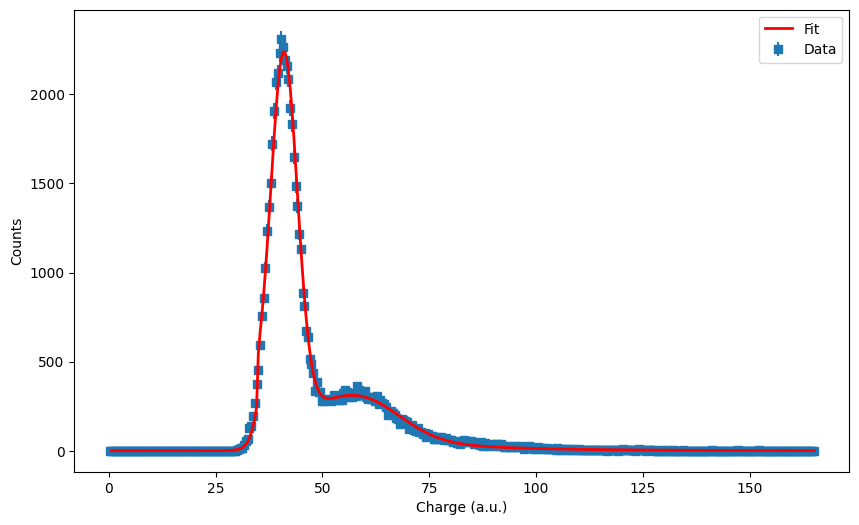

In [153]:
# Bin the data
nbins = 400
data = ak.to_numpy(ak.nansum(pmt_dsp.nnls_solution.values,axis=-1),allow_missing=False)

a,b = get_calib_curve(data,nbins,display_fit_stats=True,plot_fit=True)

Text(0.5, 0, 'charge (ADC)')

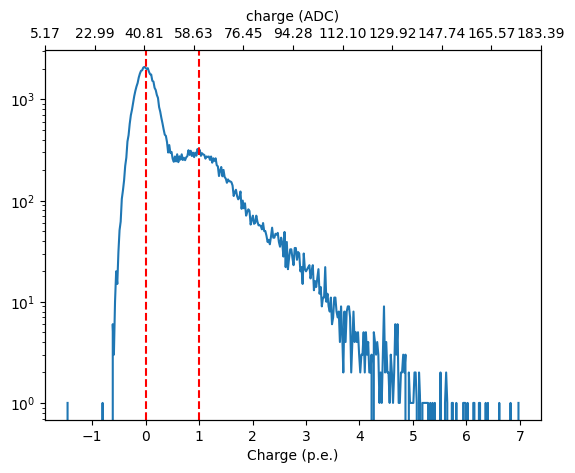

In [154]:
bins = np.linspace(0,200,nbins)
y_data, edges = np.histogram(data,bins=nbins)
bc = 0.5*(edges[1:]+edges[:-1])

# plot data (in p.e.)
fig, ax = plt.subplots()
ax.plot(bc*a+b,y_data)
ax.set_yscale("log")
ax.set_xlabel("Charge (p.e.)")
ax.axvline(x=1,color='red',ls='--')
ax.axvline(x=0,color='red',ls='--')
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))

# Create the second x-axis (in ADC)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels([f'{(tick-b)/a:.2f}' for tick in ax.get_xticks()])
ax2.set_xlabel('charge (ADC)')